<a href="https://colab.research.google.com/github/mickvanhulst/twitter_bitcoin_analysis/blob/master/models/CNN_btc_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install PyTorch

In [1]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

!pip install git+git://github.com/mickvanhulst/livelossplot.git --upgrade

tcmalloc: large alloc 1073750016 bytes == 0x5b2f8000 @  0x7eff15d412a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
0.4.0
True
  Cloning git://github.com/mickvanhulst/livelossplot.git to /tmp/pip-req-build-xhy7yijq
  Running setup.py bdist_wheel for livelossplot ... - done
  Stored in directory: /tmp/pip-ephem-wheel-cache-id3un99d/wheels/73/e2/09/79ee9f5b0be18dc9c6ee17f0dc181708c1cf9513c70053ca92
Successfully built livelossplot


# Test if GPU enabled

In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

# Load packages

In [2]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.utils.data as utils

from livelossplot import PlotLosses

from google.colab import drive

import numpy as np
import time
from sklearn.model_selection import KFold
import matplotlib
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Mount Drive and open matrices

In [5]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import re

def tryint(s):
    try:
        return int(s)
    except ValueError:
        return s
     
def alphanum_key(s):
    """ Turn a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
    """
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]

def sort_nicely(l):
    """ Sort the given list in the way that humans expect.
    
    amazing <3 RegExp
    """
    l.sort(key=alphanum_key)
    return l

In [9]:
import os

model_type = ['keywords_tfidf', 'keywords_clusters'][1]
mode = ['count', 'binary'][1]
train, test = None, None
train_classes, train_user_data, train_matrices, train_dates = None, None, None, None

base_str = '/content/gdrive/My Drive/Colab Notebooks/data/btc/{}/{}/train/'.format(model_type, mode)
files = os.listdir(base_str)
for train_file in sort_nicely(files):
    if 'c_up' in train_file:
        temp = np.load(base_str + train_file)
        if train_classes is None:
            train_classes = temp
        else:
            train_classes = np.concatenate((train_classes, temp), axis=0)
    elif 'md_up' in train_file:
        temp = np.load(base_str + train_file)
        if train_user_data is None:
            train_user_data = temp
        else:
            train_user_data = np.vstack((train_user_data, temp))
    elif 'dp_up' in train_file:
        temp = np.load(base_str + train_file)
        if train_matrices is None:
            train_matrices = temp
        else:
            train_matrices = np.vstack((train_matrices, temp))
    elif 'dt_up' in train_file:
        temp = np.load(base_str + train_file)
        if train_dates is None:
            train_dates = temp
        else:
            train_dates = np.concatenate((train_dates, temp), axis=0)

test_classes, test_user_data, test_matrices, test_dates = None, None, None, None
base_str = '/content/gdrive/My Drive/Colab Notebooks/data/btc/{}/{}/test/'.format(model_type, mode)

for test_file in sort_nicely(os.listdir(base_str)):
    if 'c_up' in test_file:
        temp = np.load(base_str + test_file)
        if test_classes is None:
            test_classes = temp
        else:
            test_classes = np.concatenate((test_classes, temp), axis=0)
    elif 'md_up' in test_file:
        temp = np.load(base_str + test_file)
        if test_user_data is None:
            test_user_data = temp
        else:
            test_user_data = np.vstack((test_user_data, temp))
    elif 'dp_up' in test_file:
        temp = np.load(base_str + test_file)
        if test_matrices is None:
            test_matrices = temp
        else:
            test_matrices = np.vstack((test_matrices, temp))
    elif 'dt_up' in test_file:
        temp = np.load(base_str + test_file)
        if test_dates is None:
            test_dates = temp
        else:
            test_dates = np.concatenate((test_dates, temp), axis=0)
            
print('Test shapes: ', test_classes.shape, test_user_data.shape, 
      test_matrices.shape, test_dates.shape)

print('Train shapes: ', train_classes.shape, train_user_data.shape, 
      train_matrices.shape, train_dates.shape)

Test shapes:  (22695,) (22695, 8) (22695, 200, 7) (22695,)
Train shapes:  (144578,) (144578, 8) (144578, 200, 7) (144578,)


In [0]:
# Re-assign tokens for train, set unknown test to zero.
# Get all users
unique_users = np.unique(train_user_data[:,-1])

# Assign users a unique id from 0 to n unique ids, 
# create a dictionairy using training data and re-use during test time.
# If users do not exist in training dict, then we assign a userId that
# doesn't occur anywhere, so that it doesn't influence our predictions.
# Normalize the userIds before hand.
user_ids = {}
for i, v in enumerate(unique_users):
    user_ids[v] = (i+1) / (len(unique_users))

for i, v in enumerate(train_user_data):
    train_user_data[i,-1] = user_ids[v[-1]]
    
    
for i, v in enumerate(test_user_data):
    try:
        test_user_data[i,-1] = user_ids[v[-1]]
    except:
        test_user_data[i,-1] = 0

In [0]:
#Normalize
train_user_data[:,:-1] = train_user_data[:,:-1] / train_user_data[:,:-1].max(axis=0)
test_user_data[:,:-1] = test_user_data[:,:-1] / train_user_data[:,:-1].max(axis=0)

In [12]:
cnt_n = 0
cnt_y = 0
for i in np.unique(test_user_data[:,-1]):
    if i in train_user_data[:,-1]:
        cnt_y += 1
    else:
        cnt_n += 1
        
cnt_n, cnt_y, train_user_data.min(), train_user_data.mean()

(1, 5929, 0.0, 0.1811176429511396)

# Device config


In [0]:
# Device configuration
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

# Process data and set parameters

In [23]:
# Hyper parameters
num_epochs = 50
num_classes = 1
batch_size = 4
learning_rate = 0.1
size_user_info = 8

print('''Occurences of zero/one vs total amount of 
classes for train and test set:
-------------------------------''')
for d in [train_classes, test_classes]:
    occ_zero = len([x for x in d if x == 0])
    occ_one = len(d) - occ_zero
    print(occ_one, occ_zero, len(d))

tensor_1 = torch.from_numpy(train_matrices)
tensor_2 = torch.from_numpy(train_classes)
tensor_3 = torch.from_numpy(train_user_data.astype(float))
tensor_4 = torch.from_numpy(train_dates.astype(float))
full_dataset = torch.utils.data.TensorDataset(tensor_1, tensor_2, tensor_3, tensor_4)

tensor_1 = torch.from_numpy(test_matrices)
tensor_2 = torch.from_numpy(test_classes)
tensor_3 = torch.from_numpy(test_user_data.astype(float))
tensor_4 = torch.from_numpy(test_dates.astype(float))

test = torch.utils.data.TensorDataset(tensor_1, tensor_2, tensor_3, tensor_4)
test_loader = torch.utils.data.DataLoader(dataset=test,
                                          batch_size=batch_size,
                                          drop_last=True,
                                          shuffle=False)

Occurences of zero/one vs total amount of 
classes for train and test set:
-------------------------------
65104 79474 144578
8149 14546 22695


# Model

## Setup Model

In [0]:
class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv1d(200, 12, kernel_size=5, stride=1, padding=1)
        self.conv2 = nn.Conv1d(12, 5, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(5*5, 10)
        self.fc3 = nn.Linear(10 + size_user_info, num_classes)
        self.out_act = nn.Sigmoid()

    def forward(self, x, user_data):
        x = x.view(batch_size, 200, 7).float()
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = torch.cat((x, user_data.float()), 1)
        x = self.fc3(x)
        x = self.out_act(x)
        return x

model = ConvNet(num_classes).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [0]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

12476

## (Optional) Load model

In [0]:
base_str = '/content/gdrive/My Drive/Colab Notebooks/data/btc'
model = model.load_state_dict(torch.load('{}/model_{}_{}_{}.ckpt'.format(
    base_str, num_epochs, batch_size, 'cluster')))


## Methods

In [0]:
def validate_model(val_loader):
    model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
    with torch.no_grad():
        correct = 0
        total = 0
        losses = []
        for images, labels, user_data, dates in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            user_data = user_data.to(device)
            outputs = model(images, user_data)
            predicted = (0.5 > outputs).float() * 1
            predicted = [x[0] for x in predicted.data.cpu().numpy()]
            loss = criterion(outputs, labels.float())
            losses.append(loss.data.cpu().numpy())
            
            total += labels.size(0)
            equals = np.sum(predicted == labels.data.cpu().numpy())
            correct += equals
        acc = 100 * correct / total
        losses = np.mean(losses)
        print('Epoch [{}/{}], val acc: {}, val loss: {}'
              .format(epoch + 1, num_epochs, acc, losses))
        return losses, acc

def train_model(train_loader):
    correct = 0
    total = 0
    losses = []
    for i, (images, labels, user_data, dates) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        user_data = user_data.to(device)
        
        # Forward pass
        outputs = model(images, user_data)
        predicted = (0.5 > outputs).float() * 1
        predicted = [x[0] for x in predicted.data.cpu().numpy()]
        loss = criterion(outputs, labels.float())
        losses.append(loss.data.cpu().numpy())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total += labels.size(0)
        equals = np.sum(predicted == labels.data.cpu().numpy())
        correct += equals

        if i % int(len(train_loader) / 3)  == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
    return np.mean(losses), 100 * correct / total


def test_model(test_loader):
    # Test the model
#     X_test_lr, y_test_lr = [], []
    model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels, user_data, dates in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            user_data = user_data.to(device)
            outputs = model(images, user_data)
            predicted = (0.5 > outputs).float() * 1
            predicted = [x[0] for x in predicted.data.cpu().numpy()]
#             X_test_lr.extend(np.concatenate((outputs.data.cpu().numpy(), 
#                                               user_data.data.cpu().numpy()), 
#                                              axis=1))
#             y_test_lr.extend(labels.data.cpu().numpy())
            total += labels.size(0)
            equals = np.sum(predicted == labels.data.cpu().numpy())
            correct += equals
        acc = 100 * correct / total
        print('Test Accuracy of the model on the test images: {} %'.format(acc))
        
    return acc

## K-Fold CV

In [0]:
# Train the model
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 
                                                       verbose=True, patience=8)
n_folds = 2
kf = KFold(n_splits=n_folds, shuffle=True)
fold_val_losses = []
saved_plots = []
file_name_base = '/content/gdrive/My Drive/Colab Notebooks/data/btc/plots/{}_fold_'.format(time.time())
fold = 0
for train_indexes, validation_indexes in kf.split(full_dataset):
    fold += 1
    liveloss = PlotLosses(save_img=True, file_name=file_name_base + str(fold) + '.png')

    train = torch.utils.data.dataset.Subset(full_dataset, train_indexes)
    validation = torch.utils.data.dataset.Subset(full_dataset, validation_indexes)
    
    model = ConvNet(num_classes).to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
    # Set train and validation data loaders.
    train_loader = torch.utils.data.DataLoader(dataset=train,
                                               batch_size=batch_size,
                                               drop_last=True,
                                               shuffle=True)
    val_loader = torch.utils.data.DataLoader(dataset=validation,
                                              batch_size=batch_size,
                                              drop_last=True,
                                              shuffle=True)
    total_step = len(train_loader)
    print('-------------------------------')
    print('Starting training for new fold')
    print('-------------------------------')
    for epoch in range(num_epochs):
        train_loss, train_acc = train_model(train_loader)
        val_loss, val_acc = validate_model(val_loader)
        scheduler.step(val_loss)
        liveloss.update({
            'log loss': train_loss,
            'val_log loss': val_loss,
            'accuracy': train_acc,
            'val_accuracy': val_acc
        })
        liveloss.draw()
    
    print('Final validation loss for current fold: {}'.format(val_loss))
    fold_val_losses.append(val_loss)
    saved_plots.append(liveloss)
    
print('-------------------------------')
print('{}-fold validation has been executed, mean validation loss: {}'.
      format(n_folds, np.mean(fold_val_losses)))

np.save('/content/gdrive/My Drive/Colab Notebooks/data/btc/plots_crossval_{}_{}_{}.npy'.
        format(num_epochs, batch_size, time.time()), np.array(saved_plots))

-------------------------------
Starting training for new fold
-------------------------------
Epoch [1/50], Step [1/18072], Loss: 0.6744


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch [1/50], Step [6025/18072], Loss: 0.7567


### Note: unfortunately the function above overwrites older plots. However, I've saved them into the list below. So you can access them by simply accessing the corresponding index.

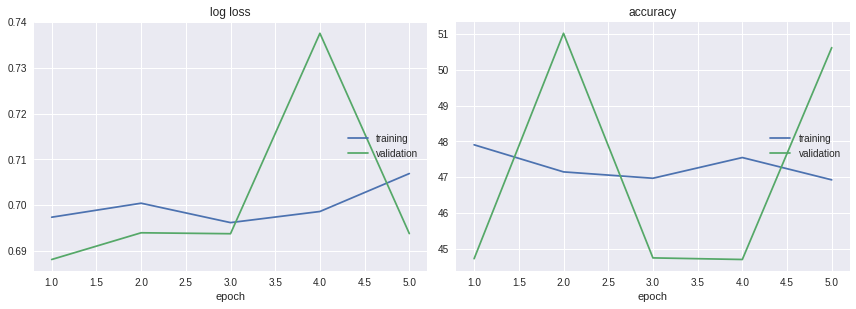

log loss:
training   (min:    0.696, max:    0.707, cur:    0.707)
validation (min:    0.688, max:    0.738, cur:    0.694)

accuracy:
training   (min:   46.925, max:   47.906, cur:   46.925)
validation (min:   44.697, max:   51.025, cur:   50.624)


In [0]:
saved_plots[1].draw()


## Train and test final model

In [0]:
# Init model
model = ConvNet(num_classes).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Set train and validation data loaders.
len_train = int(len(full_dataset) * 0.8)
len_val = len(full_dataset) - len_train
train, validation = torch.utils.data.dataset.random_split(full_dataset, [len_train, len_val])

train_loader = torch.utils.data.DataLoader(dataset=train,
                                           batch_size=batch_size,
                                           drop_last=True,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=validation,
                                          batch_size=batch_size,
                                          drop_last=True,
                                          shuffle=True)
# Train the model
total_step = len(train_loader)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 
                                                       verbose=True, patience=2)
liveloss = PlotLosses(save_img=True, file_name='/content/gdrive/My Drive/Colab Notebooks/data/btc/plots/{}_result_train.png'.format(time.time()))

for epoch in range(num_epochs):
    train_loss, train_acc = train_model(train_loader)
    val_loss, val_acc = validate_model(val_loader)
    scheduler.step(val_loss)
    liveloss.update({
        'log loss': train_loss,
        'val_log loss': val_loss,
        'accuracy': train_acc,
        'val_accuracy': val_acc
    })
    liveloss.draw()

print('Final validation loss for current fold: {}'.format(val_loss))
fold_val_losses.append(val_loss)
    
acc = test_model(val_loader)

# Save the model checkpoint
torch.save(model.state_dict(), '/content/gdrive/My Drive/Colab Notebooks/data/btc/models/model_{}_{}_{}_{}_{}.ckpt'.format(
    num_epochs, batch_size, model_type, acc, time.time()))

# Trading strategy

## Perform forward pass on training set to generate data for Logistic Regression and majority vote

In [0]:
train_loader = torch.utils.data.DataLoader(dataset=train,batch_size=batch_size, shuffle=False, drop_last=True)
train_lr = None

model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    for images, labels, user_data, dates in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        user_data = user_data.to(device)
        outputs = model(images, user_data)
        predicted = (0.5 > outputs).float() * 1
        
        predicted = np.array([x[0] for x in predicted.data.cpu().numpy()])
        outputs = np.array([x[0] for x in outputs.data.cpu().numpy()])
        labels = np.array([x for x in labels.data.cpu().numpy()])
        temp = np.dstack((outputs, labels, 
                               user_data.data.cpu().numpy()[:,-1],
                               dates.data.cpu().numpy(), predicted)).squeeze()
        if train_lr is None:
            train_lr = temp
        else:
            train_lr = np.concatenate((train_lr, temp), axis=0)

In [0]:
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False, drop_last=True)
test_lr = None

model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    for images, labels, user_data, dates in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        user_data = user_data.to(device)
        outputs = model(images, user_data)
        predicted = (0.5 > outputs).float() * 1
        
        predicted = np.array([x[0] for x in predicted.data.cpu().numpy()])
        outputs = np.array([x[0] for x in outputs.data.cpu().numpy()])
        #labels = np.array([x for x in labels.data.cpu().numpy()])
        temp = np.dstack((outputs, labels.data.cpu().numpy(), 
                               user_data.data.cpu().numpy()[:,-1],
                               dates.data.cpu().numpy(), predicted)).squeeze()
        if test_lr is None:
            test_lr = temp
        else:
            test_lr = np.concatenate((test_lr, temp), axis=0)

## Create dataframe for LR and MV

In [0]:
import pandas as pd

train_df = pd.DataFrame({'output':train_lr[:,0],'true':train_lr[:,1], 
                                   'user':train_lr[:,2], 'date':train_lr[:,3], 'pred_max':train_lr[:,4]})
test_df = pd.DataFrame({'output':test_lr[:,0],'true':test_lr[:,1], 
                                   'user':test_lr[:,2], 'date':test_lr[:,3], 'pred_max':test_lr[:,4]})

In [0]:
import seaborn 

seaborn.distplot(train_df['output'][train_df['date'] == 17548.0], bins=100)

## Perform Majority Vote and predict mean per date

In [0]:
data_MV = train_df[['date', 'output', 'true', 'pred_max']]
cnt_MV = 0
cnt_max = 0
pairs = []
dates = data_MV['date'].unique()
score = 0
for i in range(35, 75):
    threshold = i / 100
    cnt_MV = 0
    cnt_max = 0
    pairs = []
    for date in dates:
        temp = data_MV[data_MV['date'] == date]
        y_true = temp['true'].unique()[0]
        MV = temp['pred_max'].value_counts().index[0]
        max_all = temp['output'].mean()
        max_all = 1 if max_all > threshold else 0

        if y_true == MV:
            cnt_MV += 1
        if y_true == max_all:
            cnt_max += 1
            #print('correct', y_true, temp['output'].mean())
        else:
            #print('wrong', y_true, temp['output'].mean())
            pairs.append([max_all, y_true])
    new_score = cnt_max / len(dates)
    if new_score > score:
        best_thresh = threshold
        score = new_score
#print(cnt_MV / len(dates), cnt_max / len(dates), len(dates))
print('The best score was {} with threshold {}'.format(score, best_thresh))
print('Performing MV resulted in an acc of: {}'.format(cnt_MV / len(dates)))

## Use best threshold for training set on test set to measure performance

In [0]:
data_MV = test_df[['date', 'output', 'true', 'pred_max']]
cnt_max = 0
pairs = []
dates = data_MV['date'].unique()

for date in dates:
    temp = data_MV[data_MV['date'] == date]
    y_true = temp['true'].unique()[0]
    MV = temp['pred_max'].value_counts().index[0]
    max_all = temp['output'].mean()
    max_all = 1 if max_all > best_thresh else 0

    if y_true == max_all:
        cnt_max += 1
        print('correct', y_true, temp['output'].mean())
    else:
        print('wrong', y_true, temp['output'].mean())
        pairs.append([max_all, y_true])

print('The score on the test set is: {} with threshold {}'.format(cnt_max / len(dates), best_thresh))
print(len(pairs), len([x for x in pairs if x[0] == 1]), len([x for x in pairs if x[0] == 0]))

## Create required dataset for Logistic Regression

In [0]:
'''
For logistic regression we'd the following input:
[user_pred_1, .... user_pred_n]

We create a matrix with all zeroes and replace the user predictions if there
are any. If there's none, then we simply leave it at zero.

So we get a matrix per day with predictions for all users.
'''


# # Get all users
users = train_df['user'].unique()

# # Assign users a unique id from 0 to n unique ids, 
# # create a dictionairy using training data and re-use during test time.
user_ids_lr = {}
for i, v in enumerate(users):
    user_ids_lr[v] = i

# Loop over dates, check if user has prediction
X_train = None
y_train = []
cnt = 0
for date in train_df['date'].unique():
    cnt += 1
    temp = train_df[train_df['date'] == date]
    arr = np.zeros(len(users))
    for row in temp.itertuples():
        usr = row[5]
        pred = row[2]
        lbl = row[4]
        arr[user_ids_lr[usr]] = pred
    y_train.append([lbl])
    if X_train is None:
        X_train = arr
    else:
        X_train = np.vstack((X_train, arr))

y_train = np.array(y_train)  

In [0]:
# Loop over dates, check if user has prediction
X_test = None
y_test = []
cnt = 0
for date in test_df['date'].unique():
    cnt += 1
    temp = test_df[test_df['date'] == date]
    arr = np.zeros(len(users))
    for row in temp.itertuples():
        usr = row[5]
        pred = row[2]
        lbl = row[4]
        try:
            arr[user_ids_lr[usr]] = pred
        except:
            print('User {} not found'.format(usr))
    y_test.append([lbl])
    if X_test is None:
        X_test = arr
    else:
        X_test = np.vstack((X_test, arr))

y_test = np.array(y_test)  

User 1779.0 not found
User 0.16769836803601576 not found
User 1779.0 not found
User 1779.0 not found
User 1779.0 not found
User 1779.0 not found
User 1779.0 not found
User 1779.0 not found
User 1779.0 not found
User 1779.0 not found
User 1779.0 not found
User 1779.0 not found
User 1779.0 not found
User 1779.0 not found
User 1779.0 not found
User 1779.0 not found
User 1779.0 not found
User 0.9994372537985369 not found
User 1779.0 not found
User 1779.0 not found
User 1779.0 not found
User 1779.0 not found
User 1779.0 not found
User 1779.0 not found
User 1779.0 not found
User 1779.0 not found
User 1779.0 not found
User 1779.0 not found
User 1779.0 not found
User 1779.0 not found
User 1779.0 not found
User 1779.0 not found
User 1779.0 not found
User 0.9994372537985369 not found
User 1779.0 not found
User 1779.0 not found
User 1779.0 not found
User 1779.0 not found
User 1779.0 not found
User 1779.0 not found
User 1779.0 not found
User 1779.0 not found
User 1779.0 not found
User 1779.0 not f

## Perform Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression



# instantiate the model (using the default parameters)
logreg = LogisticRegression(C=0.55)

# fit the model with data
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_train)

from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_train, y_pred)
cnf_matrix

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[257,  23],
       [ 60, 187]])

In [0]:
y_pred = logreg.predict(X_test)

from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[16,  0],
       [ 6,  1]])

Text(0.5,257.44,'Predicted label')

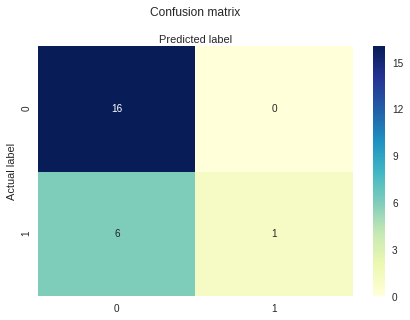

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')